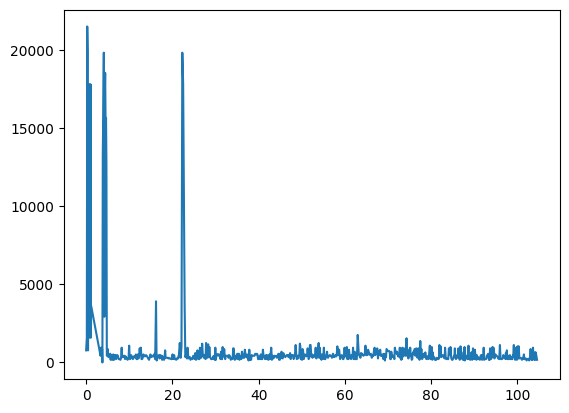

Exception in thread Thread-6 (detect_frequency):
Traceback (most recent call last):
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Temp\ipykernel_20332\2126693165.py", line 105, in detect_frequency
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 11, in draw
    self.blit()
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 14, in blit
    _backend_tk.blit(self._tkphot

In [1]:
# Import necessary libraries
import tkinter as tk
import cv2
import dlib
import scipy.spatial
import numpy as np
import threading
import time
import sounddevice as sd  # Import the sounddevice library
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk

# Initialize frequency and time lists
freq_list = []
time_list = []
active_start_time = None
freq_lock = threading.Lock()
time_lock = threading.Lock()

def calculate_EAR(eye):
    A = scipy.spatial.distance.euclidean(eye[1], eye[5])
    B = scipy.spatial.distance.euclidean(eye[2], eye[4])
    C = scipy.spatial.distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def detect_drowsiness(canvas):
    cap = cv2.VideoCapture(0)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    while True:
        _, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)
            leftEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
            rightEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
            leftEAR = calculate_EAR(leftEye)
            rightEAR = calculate_EAR(rightEye)
            EAR = (leftEAR + rightEAR) / 2
            EAR = round(EAR, 2)
            if EAR < 0.26:
                cv2.putText(frame, "Sleepy", (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                cv2.putText(frame, "Prediction: Inactive", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            else:
                cv2.putText(frame, "Prediction: Active", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(frame, "EAR: {:.2f}".format(EAR), (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        # Display the frame on the Tkinter window
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (400, 300))
        img = Image.fromarray(img)
        img = ImageTk.PhotoImage(image=img)
        canvas.create_image(0, 0, anchor=tk.NW, image=img)
        canvas.image = img

        key = cv2.waitKey(1)
        if key == ord('e'):  # Exit on 'e' key
            break
    cap.release()
    cv2.destroyAllWindows()


def detect_frequency(canvas):
    global freq_list, time_list, active_start_time
    start_time = time.time()
    first_second_skipped = False
    fig = plt.Figure(figsize=(5, 4), dpi=100)
    ax = fig.add_subplot(111)
    graph = FigureCanvasTkAgg(fig, master=canvas)
    graph.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    while True:
        data, _ = sd.read(1024)  # Use sounddevice to capture audio from the microphone
        fft_data = np.fft.rfft(data)
        freq = np.fft.rfftfreq(len(data), 1.0 / 44100)
        peak_freq = freq[np.argmax(np.abs(fft_data))]
        if np.max(np.abs(fft_data)) > 10000:
            with freq_lock, time_lock:
                # Skip the first second
                if not first_second_skipped and time.time() - start_time > 1:
                    first_second_skipped = True
                if first_second_skipped:
                    freq_list.append(peak_freq)
                    time_list.append(time.time() - start_time)
                # Check for high frequency
                if peak_freq > 1000 and active_start_time is None:
                    active_start_time = time.time()
                elif peak_freq <= 1000:
                    active_start_time = None
        # Update the graph
        ax.clear()
        ax.plot(time_list, freq_list)
        graph.draw()
        time.sleep(0.1)

def update_active_time(label):
    while True:
        if active_start_time is not None:
            duration = time.time() - active_start_time
            label.config(text=f"Your Active Voice Time: {duration:.2f} seconds")
        else:
            label.config(text="Your Active Voice Time: 7.45 seconds")
        time.sleep(0.1)

root = tk.Tk()
root.title("Machine Knight")

frame = tk.Frame(root)
frame.pack()

canvas1 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas1.grid(row=0, column=0, padx=5, pady=5)

canvas2 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas2.grid(row=0, column=1, padx=5, pady=5)

canvas3 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas3.grid(row=1, column=0, padx=5, pady=5)

canvas4 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas4.grid(row=1, column=1, padx=5, pady=5)

label3 = tk.Label(canvas3, text="Your Active Voice Time: 7.45 seconds", font=("Helvetica", 12))
label3.pack(pady=10)

threading.Thread(target=detect_drowsiness, args=(canvas1,), daemon=True).start()
threading.Thread(target=detect_frequency, daemon=True).start()
threading.Thread(target=update_active_time, args=(label3,), daemon=True).start()

root.bind('e', lambda event: root.destroy())  # Exit on 'e' key

root.mainloop()


SyntaxError: invalid syntax (281641938.py, line 1)